## Importing Skin Cancer Data

Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
# Defining the path for train and test images
#Update the paths of the train and test dataset

root_path = r'C:\Users\hp\OneDrive\Desktop\Upgrad Jupyter files\CNN\CNN Project\CNN_assignment\Skin cancer ISIC'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [3]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2234
118


#### Load using keras.preprocessing
##### Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset
#### Define some parameters for the loader:

In [20]:
batch_size = 32
img_height = 180
img_width = 180

##### Use 80% of the images for training, and 20% for validation.

In [22]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2234 files belonging to 9 classes.
Using 1788 files for training.


In [23]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2234 files belonging to 9 classes.
Using 446 files for validation.


In [24]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [26]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

## Visualize the data

Found 2234 files belonging to 9 classes.


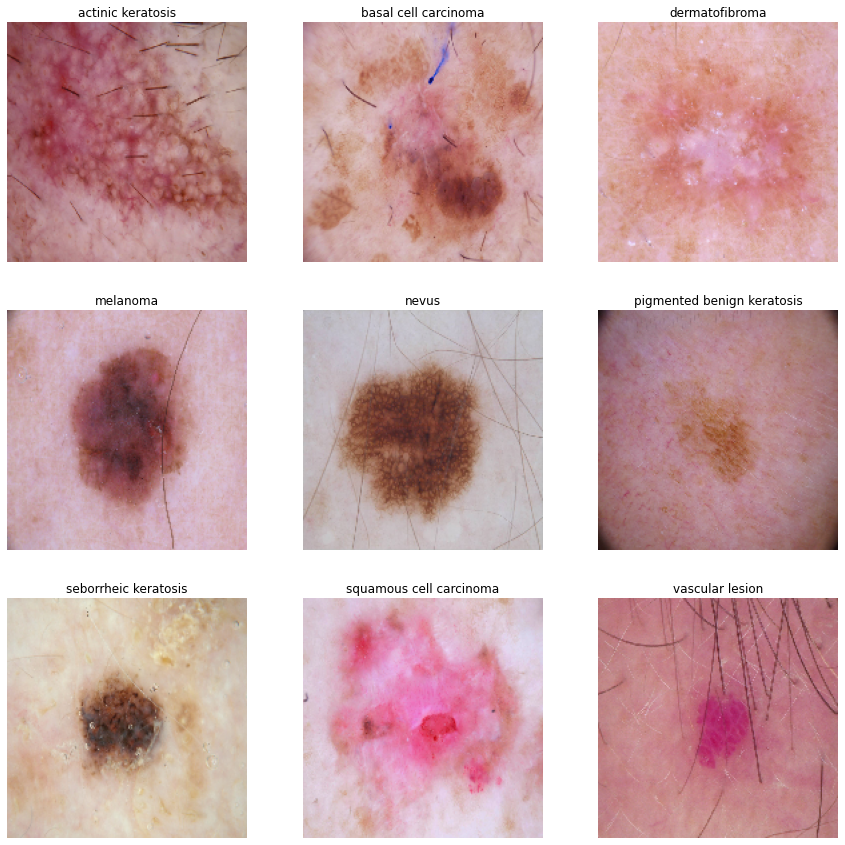

In [4]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    #print(files_path_dict[c])
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

#### The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

## Visualize distribution of classes in the training dataset.

In [5]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,371
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<AxesSubplot:xlabel='Class', ylabel='No. of Image'>

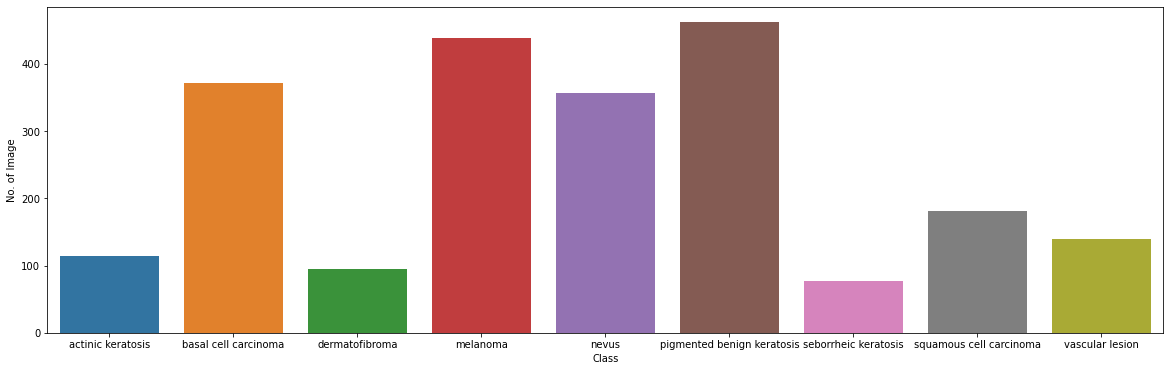

In [6]:

#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(20, 6))
sns.barplot(x="Class", y="No. of Image", data=df,
            label="Class")

###### We can see our data is imbalanced.

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

#|Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [30]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [44]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_43 (ModuleW  (None, 178, 178, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_44 (ModuleW  (None, 176, 176, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_45 (ModuleW  (None, 88, 88, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_46 (ModuleW  (None, 86, 86, 64)        18496     
 rapper)                                              

### Compile the model
#### Choose an appropirate optimiser and loss function for model training

In [32]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                               

In [34]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 66s 1s/step - loss: -57308.1562 - accuracy: 0.1711 - val_loss: -39650.4922 - val_accuracy: 0.1457
Epoch 2/20
56/56 [==============================] - 60s 1s/step - loss: -687628.4375 - accuracy: 0.1711 - val_loss: -605620.3125 - val_accuracy: 0.1457
Epoch 3/20
56/56 [==============================] - 61s 1s/step - loss: -2796502.0000 - accuracy: 0.1711 - val_loss: -3235411.0000 - val_accuracy: 0.1457
Epoch 4/20
56/56 [==============================] - 58s 1s/step - loss: -7217362.0000 - accuracy: 0.1711 - val_loss: -6777999.5000 - val_accuracy: 0.1457
Epoch 5/20
56/56 [==============================] - 59s 1s/step - loss: -14505319.0000 - accuracy: 0.1711 - val_loss: -20062688.0000 - val_accuracy: 0.1457
Epoch 6/20
56/56 [==============================] - 60s 1s/step - loss: -25424866.0000 - accuracy: 0.1711 - val_loss: -29922938.0000 - val_accuracy: 0.1457
Epoch 7/20
56/56 [==============================] - 59s 1s/step - loss: -41030

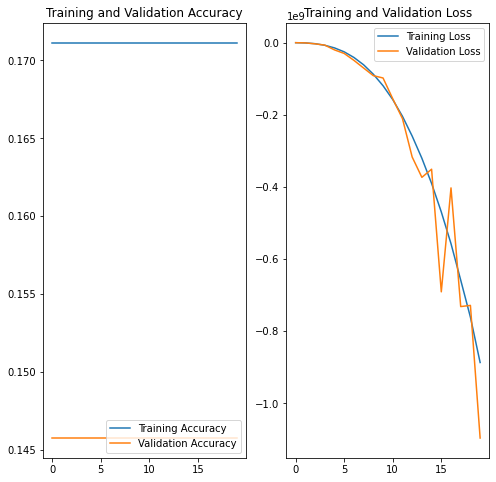

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Overfit or Underfit?

In [37]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 2s 137ms/step - loss: -1096550272.0000 - accuracy: 0.1457
Accuracy:  0.17114093899726868
Validation Accuracy:  0.14573991298675537
Loss:  -1054549824.0
Validation Loss -1096550272.0


In [39]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


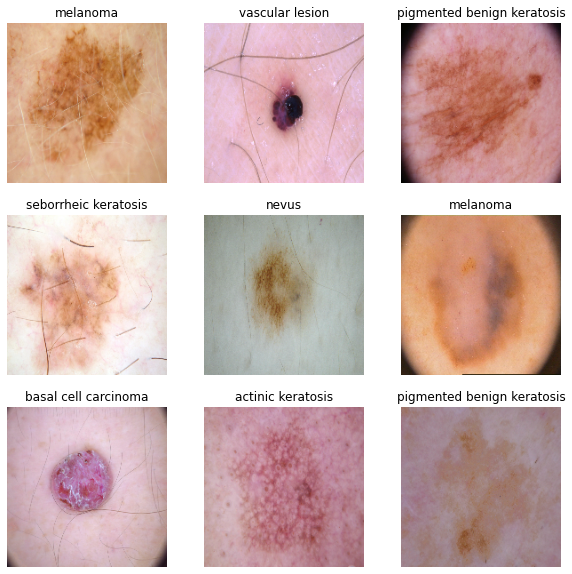

In [40]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create the model, compile and train the model

In [49]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model = Sequential()

# Increse the model size by adding another 32 layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_86 (ModuleW  (None, 180, 180, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_87 (ModuleW  (None, 180, 180, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_88 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_89 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                              

## Compiling the model

In [51]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### In order to make the optimizer converge faster and closest to the 
#### global minimum of the loss function, i used an annealing method of the learning rate (LR).
#### The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and #### the quicker is the convergence. However the sampling is
#### very poor with an high LR and the optimizer could probably fall into a local minima.

In [52]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

#### Training the model

In [56]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 49s 3s/step - loss: 2.2010 - accuracy: 0.4146 - val_loss: 1.8820 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 42s 3s/step - loss: 1.0224 - accuracy: 0.4596 - val_loss: 1.6891 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 42s 3s/step - loss: 0.9974 - accuracy: 0.4865 - val_loss: 1.6679 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 0.9913 - accuracy: 0.4371
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 [==============================] - 41s 3s/step - loss: 0.9913 - accuracy: 0.4371 - val_loss: 1.4964 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 41s 3s/step - loss: 0.9589 - accuracy: 0.4663 - val_loss: 1.5326 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 6/20
14/14 [==============================] - 41s 3s/step - loss: 

### Visualizing the results

<built-in method keys of dict object at 0x0000027A990D38C0> :


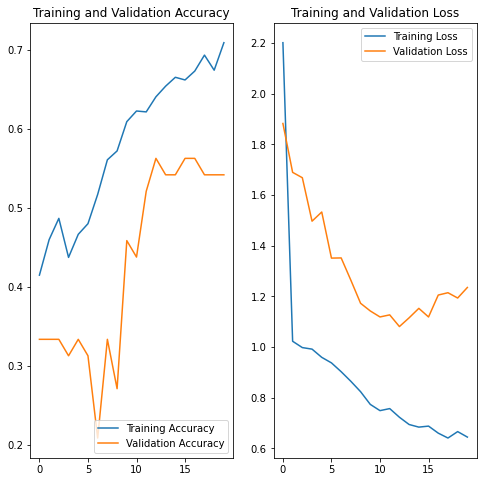

In [57]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
### Now Validation accuracy increased with training accuracy

In [61]:
#Context: Many times real life datasets can have class imbalance, 
#one class can have proportionately higher number of samples compared to the others.
#Class imbalance can have a detrimental effect on the final model quality.
#Hence as a sanity check it becomes important to check what is the distribution of classes in the data.


Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.
- Which class has the least number of samples? - Actinic Keratosos and Seborrheic keratosis
- Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis dominates the data of count more than 100 in training

In [62]:
#install Augmentor
import Augmentor

In [63]:
path_to_training_dataset =r'C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\'
for i in class_names:
    output_dir = os.path.join(path_to_training_dataset, i, "output")
    os.makedirs(output_dir, exist_ok=True)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x27AA0F56CA0>: 100%|█| 500/500 [00:01<00:


Initialised with 371 image(s) found.
Output directory set to C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x27AA0E8A4F0>: 100%|█| 500/500 [00:01<00:


Initialised with 95 image(s) found.
Output directory set to C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27AA0676EE0>: 100%|█| 500/500 [00:01<00:00, 298.23 Samples


Initialised with 438 image(s) found.
Output directory set to C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x27A9941F6A0>: 100%|█| 500/500 [00:07<00:00, 62.97 Samples


Initialised with 357 image(s) found.
Output directory set to C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x27AA0F26D00>: 100%|█| 500/500 [00:09<00:


Initialised with 462 image(s) found.
Output directory set to C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27A9940EA90>: 100%|█| 500/500 [00:01<00:00, 252.29 Samples


Initialised with 77 image(s) found.
Output directory set to C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x27AA0F5E7F0>: 100%|█| 500/500 [00:03<00:00, 131.06 Sample


Initialised with 181 image(s) found.
Output directory set to C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27AA0EEE3D0>: 100%|█| 500/500 [00:01<00:00, 318.06 Samples


Initialised with 139 image(s) found.
Output directory set to C:\\Users\\hp\\OneDrive\\Desktop\\Upgrad Jupyter files\\CNN\\CNN Project\\CNN_assignment\\Skin cancer ISIC\\Train\\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27AA1B5F370>: 100%|█| 500/500 [00:01<00:00, 295.81 Samples


In [64]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


## Model Buiding

In [65]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6734 files belonging to 9 classes.
Using 5388 files for training.


In [66]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6734 files belonging to 9 classes.
Using 1346 files for validation.


In [68]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

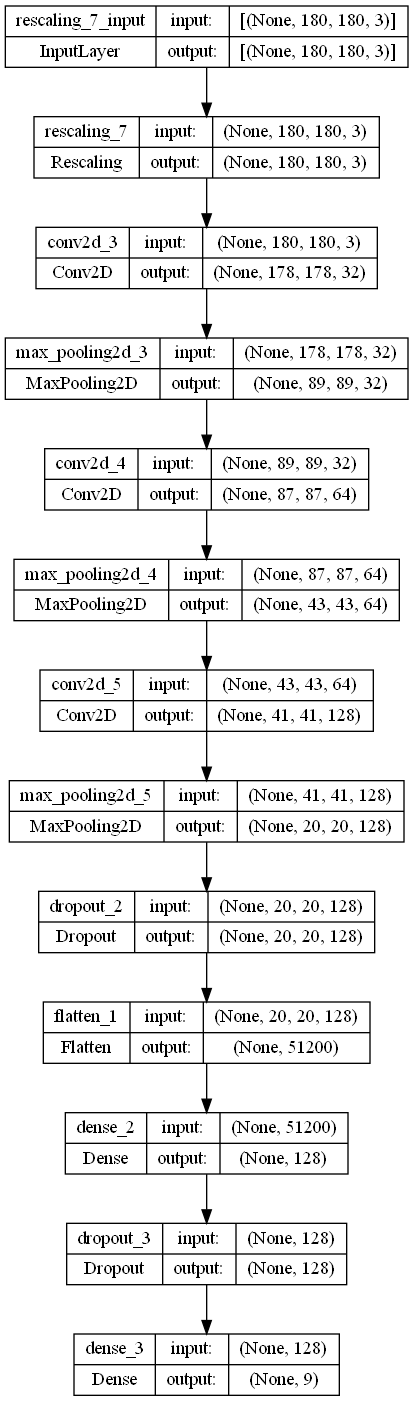

In [70]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [71]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [72]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.8857 - accuracy: 0.2764
Epoch 1: val_accuracy improved from -inf to 0.39079, saving model to model.h5
169/169 [==============================] - 85s 461ms/step - loss: 1.8857 - accuracy: 0.2764 - val_loss: 1.6107 - val_accuracy: 0.3908
Epoch 2/20


C:\Users\hp\anaconda3\lib\site-packages\keras\src\engine\training.py:3026: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - ETA: 0s - loss: 1.5172 - accuracy: 0.4245
Epoch 2: val_accuracy improved from 0.39079 to 0.41828, saving model to model.h5
169/169 [==============================] - 78s 461ms/step - loss: 1.5172 - accuracy: 0.4245 - val_loss: 1.4507 - val_accuracy: 0.4183
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3356 - accuracy: 0.5030
Epoch 3: val_accuracy improved from 0.41828 to 0.52452, saving model to model.h5
169/169 [==============================] - 81s 478ms/step - loss: 1.3356 - accuracy: 0.5030 - val_loss: 1.2784 - val_accuracy: 0.5245
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.2228 - accuracy: 0.5494
Epoch 4: val_accuracy improved from 0.52452 to 0.58172, saving model to model.h5
169/169 [==============================] - 81s 477ms/step - loss: 1.2228 - accuracy: 0.5494 - val_loss: 1.1687 - val_accuracy: 0.5817
Epoch 5/20
169/169 [==============================] - ETA: 0s - loss: 1.1027 -

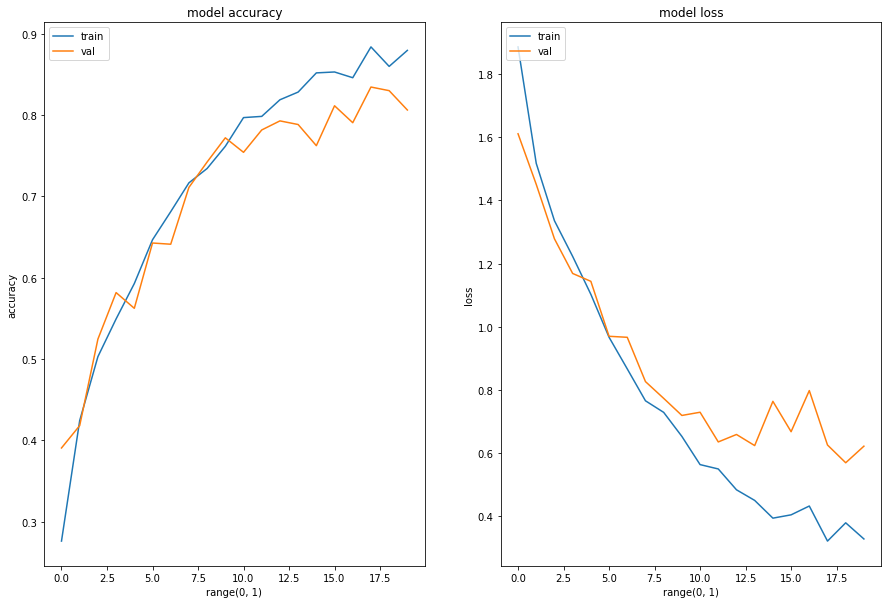

In [73]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Modell Prediction

1/1 [==============================] - 0s 75ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


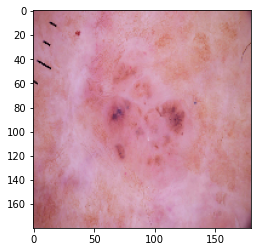

In [74]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )


In [76]:
# Did you get rid of underfitting/overfitting? Did class rebalance help?
# The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced But it reduced the Acurracy very low

# Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

# Then we introduced dropout and ImageDataGenerator which reduced the over fit

# At last we tried Batch Normalization and Augumentation which really helped in carry forward